# Import libraries

In [ ]:
#Import libraries
import joblib
import matplotlib.pyplot    as plt
import numpy                as np
import pandas               as pd
import pickle
import plotly.express       as px
import plotly.graph_objects as go
import re
import seaborn              as sns
import warnings
import sklearn

from sklearn.compose          import ColumnTransformer
from sklearn.datasets         import fetch_openml
from sklearn.ensemble         import RandomForestRegressor
from sklearn.impute           import SimpleImputer
from sklearn.metrics          import mean_absolute_percentage_error, mean_absolute_error, r2_score
from sklearn.model_selection  import train_test_split, GridSearchCV
from sklearn.pipeline         import Pipeline
from sklearn.preprocessing    import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn                  import set_config

set_config(display="diagram")
sns.set_theme(style="white")

# Read data

In [ ]:
#Read data
raw_data_dir = '/content/drive/MyDrive/DS4A/data/raw/'
interim_data_dir = '/content/drive/MyDrive/DS4A/data/interim/'
procesed_data_dir = '/content/drive/MyDrive/DS4A/data/processed/'
models_dir = '/content/drive/MyDrive/DS4A/models/'

df_train = pd.read_csv(procesed_data_dir+'df_train.csv')
df_test = pd.read_csv(procesed_data_dir+'df_test.csv')

display(df_train.head(5))
display(df_test.head(5))

,id,start_date,lat,lon,l5,price,property_type,bedrooms_prep,bath_prep,area_prep
0,zIFYDamawEDtYa6s+vK2Dw==,2021-07-26,NaN,NaN,Santa Fe,72000000.0,Casa,3.0,1.0,224.0
1,fDrS2glBKkR3xm1b807MWQ==,2021-06-23,4.725,-74.043,Usaquén,381000000.0,Apartamento,3.0,2.0,81.0
2,gmtFWD6hMs9hKml0Pkofsw==,2021-02-25,4.728,-74.052,NaN,270000000.0,Apartamento,2.0,2.0,43.0
3,CuRDlEanlk0YFwUJgOJhyg==,2020-09-16,4.756,-74.081,Suba,224000000.0,Apartamento,3.0,2.0,72.0
4,ReDLfSoQzFKuXg6ui6jFEg==,2020-08-19,4.732,-74.074,Suba,515000000.0,Apartamento,3.0,2.0,114.0


,id,start_date,lat,lon,l5,price,property_type,bedrooms_prep,bath_prep,area_prep
0,iIfkO5O2IjUSRC6emKPdzA==,2021-04-16,4.693646,-74.059749,Suba,1.200000e+09,Casa,1.0,5.0,243.0
1,urF8fuuKcO/UmkCCqFaIwg==,2021-01-06,4.679000,-74.045000,Chapinero,4.400000e+08,Apartamento,2.0,2.0,90.0
2,DTF/UL17F+9woCfKIJ55/g==,2021-02-02,4.761000,-74.028000,Usaquén,1.700000e+08,Apartamento,2.0,1.0,44.0
3,YPQ0UXrI7ZvRIEg5fprh5w==,2021-03-09,4.673064,-74.058715,Chapinero,1.600000e+09,Apartamento,2.0,2.0,142.0
4,KqBDY7lEsoBXpXA3Zvg8/A==,2021-05-05,NaN,NaN,NaN,6.500000e+08,Casa,5.0,4.0,400.0


In [ ]:
#Check data types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28187 entries, 0 to 28186
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             28187 non-null  object 
 1   start_date     28187 non-null  object 
 2   lat            26771 non-null  float64
 3   lon            26771 non-null  float64
 4   l5             25344 non-null  object 
 5   price          28187 non-null  float64
 6   property_type  28187 non-null  object 
 7   bedrooms_prep  24484 non-null  float64
 8   bath_prep      24251 non-null  float64
 9   area_prep      28187 non-null  float64
dtypes: float64(6), object(4)
memory usage: 2.2+ MB


In [ ]:
#Check missing values
df_train.isna().sum()/df_train.shape[0]

id               0.000000
start_date       0.000000
lat              0.050236
lon              0.050236
l5               0.100862
price            0.000000
property_type    0.000000
bedrooms_prep    0.131373
bath_prep        0.139639
area_prep        0.000000
dtype: float64

In [ ]:
#Drop id and start_date columns
drop_cols = ['id', 'start_date']
df_train = df_train.drop(drop_cols, axis='columns')
df_test = df_test.drop(drop_cols, axis='columns')

In [ ]:
X_train = df_train.drop(['price'], axis='columns')
y_train = df_train['price']

X_test = df_test.drop(['price'], axis='columns')
y_test = df_test['price']

# Level-Level regression

## Cross-validation and grid search

Here we will apply different preprocessing and feature extraction pipelines to different subsets of features, using `ColumnTransformer`

The numeric data will standard-scaled after mean or median imputation. The categorical data is one-hot encoded via `OneHotEncoder` after most-frequent imputation, which creates a new category for missing values.

Finally, the preprocessing pipeline is integrated in a full prediction pipeline using `Pipeline`, together with a simple classification model.

In [ ]:
#Preprocessing pipelines for both numeric and categorical data

numeric_features = ['lat', 'lon', 'bath_prep', 'bedrooms_prep', 'area_prep']
cat_features = ['l5', 'property_type']

categoric_transformer = Pipeline(
    [('imputer', SimpleImputer(strategy='most_frequent')),
     ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))]
    )

numeric_transformer = Pipeline(
    [('imputer', SimpleImputer()),
     ('scaler', StandardScaler())]
     )

preprocessor = ColumnTransformer(
    [('num', numeric_transformer, numeric_features),
     ('cat', categoric_transformer, cat_features)],
    )

#Append regressor to preprocessing pipeline. Now we have a full prediction pipeline.
rdf_pipe = Pipeline(
    [('preprocessor', preprocessor),
     ('rdf', RandomForestRegressor(n_jobs=-1, random_state=1234))]
     )

In [ ]:
#Using grid search to hyperparameters tuning
#We will search for both the imputer strategy of the numeric preprocessing and the regularization parameter

param_grid = {
    'rdf__n_estimators': [100, 150, 200],
    'rdf__max_depth': [9, 10, 11],
    'rdf__max_features':[2, 4, 6]
    }

scores = ['r2',
          'neg_mean_absolute_error',
          'neg_mean_absolute_percentage_error']

grid_search = GridSearchCV(rdf_pipe, param_grid,
                           cv=10, scoring=scores,
                           refit='r2',
                           n_jobs=-1
                           )

#This is a representation of the pipeline used
grid_search

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['lat',
                                                                          'lon',
                                                                          'bath_prep',
                                                                          'bedrooms_prep',
                                                                          'area_prep']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['l5',
                                                                          'property_type'])])),
                                       ('rdf',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=1234))]),
             n_jobs=-1,
             param_grid={'rdf__max_depth': [9, 10, 11],
                         'rdf__max_features': [2, 4, 6],
                         'rdf__n_estimators': [100, 150, 200]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

In [ ]:
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Best params:
{'rdf__max_depth': 11, 'rdf__max_features': 6, 'rdf__n_estimators': 150}


In [ ]:
#Cross-validation and grid search results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results[["mean_test_r2",
                         "mean_test_neg_mean_absolute_percentage_error",
                         'mean_test_neg_mean_absolute_error',
                         "param_rdf__n_estimators",
                         "param_rdf__max_depth",
                         'param_rdf__max_features']]
cv_results = cv_results.sort_values("mean_test_r2", ascending=False)
display(cv_results.head())
cv_results.shape

,mean_test_r2,mean_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_error,param_rdf__n_estimators,param_rdf__max_depth,param_rdf__max_features
25,0.869786,-0.228658,-1.348157e+08,150,11,6
24,0.869683,-0.228390,-1.347691e+08,100,11,6
26,0.869465,-0.229340,-1.350269e+08,200,11,6
16,0.856479,-0.245470,-1.429113e+08,150,10,6
15,0.856048,-0.245538,-1.430212e+08,100,10,6


(27, 6)

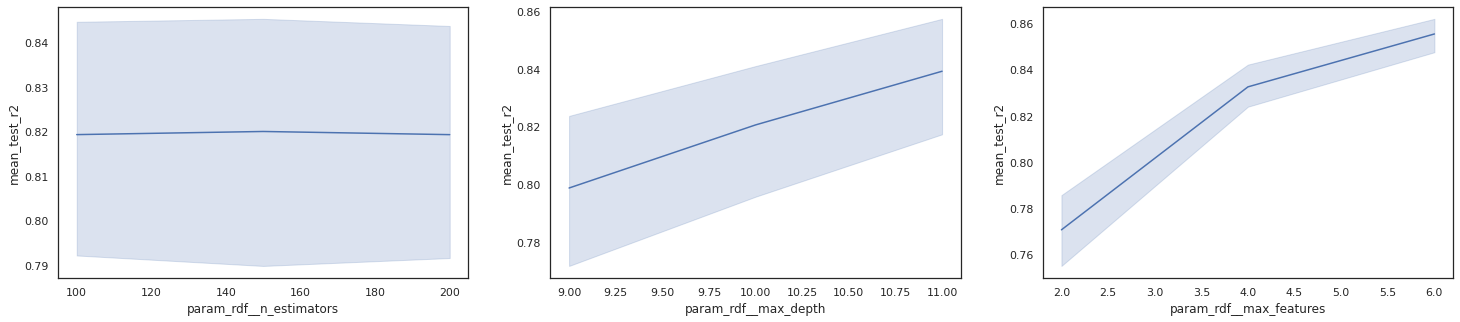

In [ ]:
#Plot the result score
fig, axes = plt.subplots(1, 3, figsize=(25, 5))
sns.lineplot(data=cv_results, x="param_rdf__n_estimators", y="mean_test_r2", ax=axes[0])
sns.lineplot(data=cv_results, x="param_rdf__max_depth", y="mean_test_r2", ax=axes[1])
sns.lineplot(data=cv_results, x="param_rdf__max_features", y="mean_test_r2", ax=axes[2])

## Fit the model in the whole train set

In [ ]:
#The best estimator is a pipeline and it can be use to predict in test set
best_estimator_pipeline = grid_search.best_estimator_
best_estimator_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['lat', 'lon', 'bath_prep',
                                                   'bedrooms_prep',
                                                   'area_prep']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['l5', 'property_type'])])),
                ('rdf',
                 RandomForestRegressor(max_depth=11, max_features=6,
                                       n_estimators=150, n_jobs=-1,
                                       random_state=1234))])

In [ ]:
#Fit ridge regression with preprocessing in train set and predict in test set
best_estimator_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['lat', 'lon', 'bath_prep',
                                                   'bedrooms_prep',
                                                   'area_prep']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['l5', 'property_type'])])),
                ('rdf',
                 RandomForestRegressor(max_depth=11, max_features=6,
                                       n_estimators=150, n_jobs=-1,
                                       random_state=1234))])

In [ ]:
standar_num = list(best_estimator_pipeline['preprocessor'].transformers_[0][1]['scaler'].get_feature_names_out(numeric_features))
onehot_cat = list(best_estimator_pipeline['preprocessor'].transformers_[1][1]['encoder'].get_feature_names_out(cat_features))
new_feat = standar_num + onehot_cat

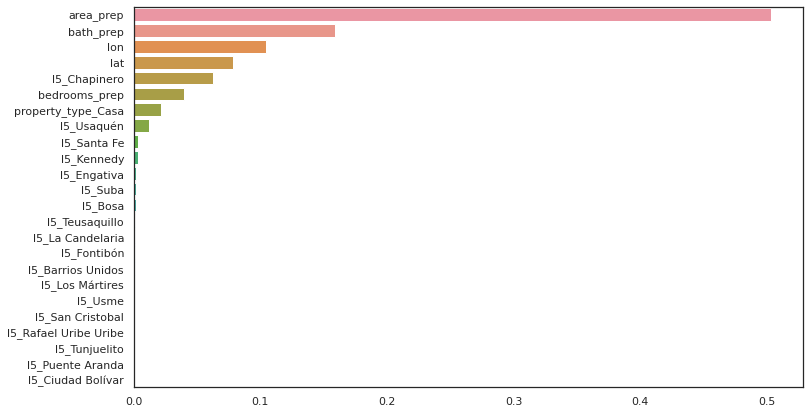

In [ ]:
feat_importance = pd.Series(best_estimator_pipeline['rdf'].feature_importances_,
                            index=new_feat)
feat_importance = feat_importance.sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(y=feat_importance.index, x=feat_importance.values, )

In [ ]:
#Results
y_pred_train = best_estimator_pipeline.predict(X_train)
y_pred_test = best_estimator_pipeline.predict(X_test)

print("MAPE score in train: %.3f" % mean_absolute_percentage_error(y_train, y_pred_train))
print("MAPE score in test: %.3f" % mean_absolute_percentage_error(y_test, y_pred_test))

print("MAE score in train: %.3f" % mean_absolute_error(y_train, y_pred_train))
print("MAE score in test: %.3f" % mean_absolute_error(y_test, y_pred_test))

print("R2 score in train: %.3f" % r2_score(y_train, y_pred_train))
print("R2 score in test: %.3f" % r2_score(y_test, y_pred_test))

MAPE score in train: 0.210
MAPE score in test: 0.269
MAE score in train: 120528076.642
MAE score in test: 139693356.933
R2 score in train: 0.907
R2 score in test: 0.863


In [ ]:
#Export model
joblib.dump(best_estimator_pipeline, models_dir+'randomforest_model_1.joblib')

['/content/drive/MyDrive/DS4A/models/randomforest_model_1.joblib']